#Student Info

name: Ufuk Cem Birbiri

M2 Data Science & AI student

# Computer Vision Assignment
In this assignment you will be required to create a CV classifier on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. To achieve this you will be required to create and compare different classifier. More precisely you will be asked to:

*   Create the right data-loading pipeline (e.g., Data augmentation, batch size, loading strategy, etc.)
*   Select the proper transfer learning strategy (e.g., fine-tuning, transfer learning, training from scratch) 
*   Select the right hyperparameters (e.g., learning rate, optimizer)

More importantly, you are required to **explain** the choices that you make. To do so, you can also perform different experiments (e.g., comparing two different learning rates or transfer learning strategies) and provide a comment on why one perform better than the other at the end of the notebook. 
You can re-use the notebook that we have been using in the classroom.

You are only provided with:


*   The dataset (directly provided by Torchvision)
*   The neural architecture: a Resnet18 `network = torchvision.models.resnet18()`






In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Loading Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify ten different objects: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*. We have 50000 training images and 10000 validation images.

We can directly load the dataset from its torchvision class.

In [2]:
train_dir = 'cifar10_train'
val_dir = "cifar10_val"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
     ## FILL IT YOURSELF!
     transforms.RandomResizedCrop(224, [0.75, 1.0]),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
# Just normalization for validation
val_transforms = transforms.Compose([
     ## FILL IT YOURSELF!
     transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_dataset = torchvision.datasets.CIFAR10(root=train_dir, train=True, 
                                             transform=train_transforms, download=True)
val_dataset = torchvision.datasets.CIFAR10(root=val_dir,train=False, 
                                           transform=val_transforms, download=True)
                                             
train_size = len(train_dataset)
val_size = len(val_dataset)
print("Dataset sizes:", train_size, val_size )
class_names = train_dataset.classes
print("Class names:", class_names)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_train/cifar-10-python.tar.gz to cifar10_train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_val/cifar-10-python.tar.gz to cifar10_val
Dataset sizes: 50000 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one more parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk. 

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 16 images in parallel (4 per thread). 


In [3]:
batch_size = 256
train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True, 
                                       batch_size=batch_size, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_dataset, 
                                     batch_size=batch_size*2, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



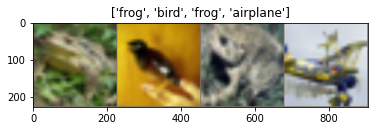

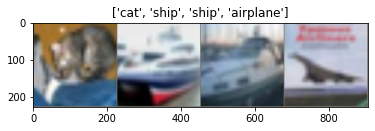

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # reconvert to numpy tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                  # take out normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                   # pause a bit so that plots are updated


# Get a batch of training data
x, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

# Redo for valid data
x, classes = next(iter(val_dl))
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

#0. Functions for train and validation data

These functions are adapted from the Notebook that we used in the class. However I added a parameter to the train_model function called 'print_flag'. If we want to print the train accuracy, validation accuracy and the loss in each epoch we set the print_flag as 1. Since I will do a lot of experiments, I don't wanna print every epoch in each experiment.


In [4]:
# Function to iterate over data while training
def train_one_epoch(model, train_dl, loss, optim, device):        
    model.train()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        # zero the parameter gradients
        optim.zero_grad()
        # forward
        outputs = model(x)
        preds = torch.argmax(outputs, 1)
        l = loss(outputs, y)
        # backward + optimize 
        l.backward()
        optim.step()
        # statistics
        cur_loss += l.item() * x.size(0)
        cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(train_dl.dataset)
    epoch_acc = cur_acc.double() / len(train_dl.dataset)
    return epoch_loss, epoch_acc
    
# Function to iterate over data while evaluating
def eval_one_epoch(model, val_dl, loss, device):        
    model.eval()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            
            # forward
            outputs = model(x)
            preds = torch.argmax(outputs, 1)
            l = loss(outputs, y)

            # statistics
            cur_loss += l.item() * x.size(0)
            cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(val_dl.dataset)
    epoch_acc = cur_acc.double() / len(val_dl.dataset)
    return epoch_loss, epoch_acc

def train_model(model, train_dl, val_dl, loss, optim, num_epochs=25, print_flag=0):
    model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        if print_flag==1:
          print(f'Epoch {epoch}/{num_epochs - 1}')
          print('-' * 10)

        
        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        if print_flag==1:
          print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        if print_flag==1:
          print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "temp_model.pt")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load("temp_model.pt"))
    return model

### Visualizing the model predictions

Generic function to display model  predictions for a few images.




In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (x, y) in enumerate(val_dl):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            for j in range(x.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(x.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Using torch.data.Subset(dataset, indexes) to use a smaller version of the dataset



I will only use the first 500 images in the train and val datasets to ensure  my code is working. Then I will use the whole dataset to interpret the results.

In [6]:
#Take the indexes of first 500 images
subset_indexes=[i for i in range(500)]
#Use torch.utils.data.Subset
train_subset = torch.utils.data.Subset(train_dataset, subset_indexes)
val_subset = torch.utils.data.Subset(val_dataset, subset_indexes)

batch_size = 256
train_dl_subset = torch.utils.data.DataLoader(train_subset, shuffle=True, 
                                       batch_size=batch_size, num_workers=4)
val_dl_subset = torch.utils.data.DataLoader(val_subset, 
                                     batch_size=batch_size*2, num_workers=4)

#1. Select and compare different transfer - learning strategy
You need to compare the 3 learning strategy and comment the results obtained:


*   Transfer Learning (remember to directly extract the features!)
*   Fine tuning 
*   Training from scratch


Start simple! Traning from scratch may be very expensive with this dataset since we have 50000 images. 

Also, to ensure that your code is working, you can use `torch.data.Subset(dataset, indexes)` to use a smaller version of the dataset


##1.1 Transfer Learning 

Before starting investigation of different learning techniques, I need to mention that hyper-parameters are fixed in each model:

*   learning rate = 1e-3
*   number of epochs = 20
*   loss = nn.CrossEntropyLoss()
*   optimizer = optim.AdamW()
*   batch size = 256

In the last part of the assignment, I will search for the best hyper-parameters for the best model.


In transfer learning, we have two options:


   



*   **A.** Pass to the optimizer only the weights of last layer, freeze all the other layers except the final layer and do not compute the gradients(except the last layer)
*   **B.** Create a new dataset by extract image futures from the data. Then build a network with only one Linear layer and train that layer. This option is faster since we train
 only one layer in the network.




###1.1.A 



*   In this case we will freeze the gradients of all the layers(except the last Linear layer), so that the gradients will not be computed, so that there will be no 'learning' in these layers. We do the freezing by setting the ``requires_grad = False``. Also, we will pass only the last linear layer's weights to our optimizer, that means the 'learning' will happen only in the last linear layer.
*   The data will flow forward and backward into the all layers in each epoch. However, gradient calculation will happen only in the last layer ------> this will make things faster.



In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13645787032052580045
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13926924288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8132539403787460853
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [9]:
from torchvision.models import ResNet18_Weights

#define the model
model_Feature_Extraction_A = models.resnet18(weights=ResNet18_Weights)

#Freeze the layers:
for param in model_Feature_Extraction_A.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_Feature_Extraction_A.fc.in_features
#Define the last Linear layer:
model_Feature_Extraction_A.fc = nn.Linear(num_ftrs, 10)

model_feature_extraction_A = model_Feature_Extraction_A.to(device)

# Only parameters of final layer are being optimized as opposed to before
optimizer_fe = optim.AdamW(model_Feature_Extraction_A.fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
# Train and evaluate
model_Feature_Extraction_A = train_model(model_Feature_Extraction_A, train_dl, val_dl, loss, optimizer_fe,
                         num_epochs=20, print_flag=1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/19
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 1.0935 Acc: 0.6583
Val Loss: 0.7956 Acc: 0.7403

Epoch 1/19
----------
Train Loss: 0.7528 Acc: 0.7484
Val Loss: 0.7188 Acc: 0.7593

Epoch 2/19
----------
Train Loss: 0.7061 Acc: 0.7598
Val Loss: 0.6877 Acc: 0.7663

Epoch 3/19
----------
Train Loss: 0.6773 Acc: 0.7665
Val Loss: 0.6664 Acc: 0.7729

Epoch 4/19
----------
Train Loss: 0.6608 Acc: 0.7725
Val Loss: 0.6724 Acc: 0.7696

Epoch 5/19
----------
Train Loss: 0.6545 Acc: 0.7740
Val Loss: 0.6523 Acc: 0.7770

Epoch 6/19
----------
Train Loss: 0.6464 Acc: 0.7760
Val Loss: 0.6501 Acc: 0.7786

Epoch 7/19
----------
Train Loss: 0.6365 Acc: 0.7795
Val Loss: 0.6458 Acc: 0.7770

Epoch 8/19
----------
Train Loss: 0.6381 Acc: 0.7777
Val Loss: 0.6473 Acc: 0.7793

Epoch 9/19
----------
Train Loss: 0.6298 Acc: 0.7803
Val Loss: 0.6338 Acc: 0.7827

Epoch 10/19
----------
Train Loss: 0.6307 Acc: 0.7807
Val Loss: 0.6366 Acc: 0.7813

Epoch 11/19
----------
Train Loss: 0.6296 Acc: 0.7801
Val Loss: 0.6292 Acc: 0.7831

Epoch 12/19
----------
T

We got the best validation accuracy as 0.785

###1.1.B

In this option we use the Resnet18 network as a feature extractor of our dataset. We do the following steps:


1.   Define a Resnet18 model with pretrained Resnet18 weights
2.   Remove the last fully-connected layer of the model and put an ``torch.nn.Identity()``. This layer will just return the input without any manipulation.
3.   Forward the train data from the netwrok just once. At the end of this step we will have the image features created by this network and actually we have created a new dataset! (We didn't use the data augmentation this time
4.  Load the new dataset to a DataLoader
5.  Do the steps 3 and 4 for the validation data too
6.  Build a network with only one layer that is a Linear layer.
7.  Give this network's parameters to the optimizer so that only this layer will be in the learning process.
8.  Train the model




In [11]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torchvision.models import ResNet18_Weights

#Define the feature extracted network:
model_Feature_Extraction_B = models.resnet18(weights=ResNet18_Weights)
num_ftrs = model_Feature_Extraction_B.fc.in_features
#Put the identity layer at the end of the network and remove the Linear layer:
model_Feature_Extraction_B.fc = torch.nn.Identity()

#Extract features and create a new dataset:
def extract_features(model, train_dl, device):
    model.to(device)
    x_extr, y_extr = [], []
    with torch.no_grad():
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            preds = model_Feature_Extraction_B(x)
            #print(preds.size())
            x_extr.append(preds)
            y_extr.append(y)
        x_extr = torch.cat(x_extr, dim=0)
        y_extr = torch.cat(y_extr, dim=0)
        dataset_extr = TensorDataset(x_extr, y_extr)  
    return dataset_extr

# Extract the training dataset
trainset_extr = extract_features(model_Feature_Extraction_B, train_dl, device)
#Put the new training dataset into a DataLoader
train_dl_extr = DataLoader(trainset_extr, batch_size=256, shuffle=True)

# Extract the validation dataset
valset_extr = extract_features(model_Feature_Extraction_B, val_dl, device)
#Put the new validation dataset into a DataLoader
val_dl_extr = DataLoader(trainset_extr, batch_size=256)

In [12]:
model_fe2 = nn.Linear(num_ftrs, 10)
optimizer_fe2 = optim.AdamW(model_fe2.parameters(),lr=1e-3)
loss = nn.CrossEntropyLoss()


train_model(model_fe2, train_dl_extr, val_dl_extr, loss, optimizer_fe2, num_epochs=20, print_flag=1)

Epoch 0/19
----------
Train Loss: 1.1191 Acc: 0.6488
Val Loss: 0.7969 Acc: 0.7416

Epoch 1/19
----------
Train Loss: 0.7473 Acc: 0.7523
Val Loss: 0.7136 Acc: 0.7592

Epoch 2/19
----------
Train Loss: 0.6905 Acc: 0.7678
Val Loss: 0.6694 Acc: 0.7729

Epoch 3/19
----------
Train Loss: 0.6653 Acc: 0.7725
Val Loss: 0.6450 Acc: 0.7812

Epoch 4/19
----------
Train Loss: 0.6495 Acc: 0.7772
Val Loss: 0.6383 Acc: 0.7816

Epoch 5/19
----------
Train Loss: 0.6399 Acc: 0.7807
Val Loss: 0.6295 Acc: 0.7842

Epoch 6/19
----------
Train Loss: 0.6295 Acc: 0.7842
Val Loss: 0.6280 Acc: 0.7823

Epoch 7/19
----------
Train Loss: 0.6243 Acc: 0.7854
Val Loss: 0.6105 Acc: 0.7899

Epoch 8/19
----------
Train Loss: 0.6182 Acc: 0.7870
Val Loss: 0.6076 Acc: 0.7896

Epoch 9/19
----------
Train Loss: 0.6164 Acc: 0.7874
Val Loss: 0.6019 Acc: 0.7925

Epoch 10/19
----------
Train Loss: 0.6099 Acc: 0.7886
Val Loss: 0.6069 Acc: 0.7895

Epoch 11/19
----------
Train Loss: 0.6077 Acc: 0.7898
Val Loss: 0.5941 Acc: 0.7959

Ep

Linear(in_features=512, out_features=10, bias=True)

We got the best validation accuracy as 0.797

##1.2 Fine Tuning

In fine tuning a CNN, we don't initialize the networks weights to random or a specific values, instead we use weights of a pretrained network. Since in this homework we are using Resnet18, we will use its weights(``weights=torchvision.models.ResNet18_Weights``). We will apply the following steps:

1.   Define the Resnet18 model from torch vision library
2.   Assign the pretrained Resnet18 weights to our model
3.   Define a new Linear layer ``nn.Linear()`` for the last layer of our network: We are doing this because we need to adapt the Resnet18 model to our dataset. We have 10 classes to predict, so the last Linear layer output should be 10.

Let's build our network:




In [13]:
from torchvision.models import ResNet18_Weights

#Define the original Resnet18 model:
model_FineTuning = models.resnet18(weights=ResNet18_Weights)

#Take the number of input features of the last Linear layer of the original Resnet18 model. Call it num_input_features
num_input_features = model_FineTuning.fc.in_features
#Create our new Linear layer with the number of classes=10
model_FineTuning.fc = nn.Linear(num_input_features, 10)

model_FineTuning = model_FineTuning.to(device)
optimizer_ft = optim.AdamW(model_FineTuning.parameters(), lr=1e-3)

loss = nn.CrossEntropyLoss()

# Train and evaluate
model_FineTuning = train_model(model_FineTuning, train_dl, val_dl, loss, optimizer_ft, 
                       num_epochs=20, print_flag=1)

Epoch 0/19
----------
Train Loss: 0.4723 Acc: 0.8373
Val Loss: 0.4910 Acc: 0.8387

Epoch 1/19
----------
Train Loss: 0.2830 Acc: 0.9029
Val Loss: 0.3493 Acc: 0.8794

Epoch 2/19
----------
Train Loss: 0.2222 Acc: 0.9244
Val Loss: 0.2931 Acc: 0.9015

Epoch 3/19
----------
Train Loss: 0.1852 Acc: 0.9361
Val Loss: 0.3157 Acc: 0.8936

Epoch 4/19
----------
Train Loss: 0.1595 Acc: 0.9444
Val Loss: 0.3031 Acc: 0.9010

Epoch 5/19
----------
Train Loss: 0.1497 Acc: 0.9472
Val Loss: 0.2489 Acc: 0.9203

Epoch 6/19
----------
Train Loss: 0.1248 Acc: 0.9564
Val Loss: 0.2384 Acc: 0.9191

Epoch 7/19
----------
Train Loss: 0.1105 Acc: 0.9612
Val Loss: 0.2432 Acc: 0.9186

Epoch 8/19
----------
Train Loss: 0.1003 Acc: 0.9654
Val Loss: 0.2761 Acc: 0.9122

Epoch 9/19
----------
Train Loss: 0.1001 Acc: 0.9645
Val Loss: 0.2412 Acc: 0.9252

Epoch 10/19
----------
Train Loss: 0.0874 Acc: 0.9688
Val Loss: 0.2516 Acc: 0.9268

Epoch 11/19
----------
Train Loss: 0.0780 Acc: 0.9731
Val Loss: 0.2504 Acc: 0.9262

Ep

With fine tunning model, we get the 0.932 accuracy in validation dataset.

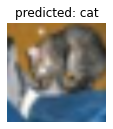

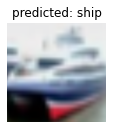

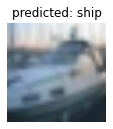

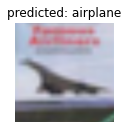

In [15]:
#Let's visualize some results:
visualize_model(model_FineTuning,4)

##1.3 Training from scratch

Training a Resnet18 model from scratch is easy. We just define the pre-implemented Resnet18 network from the torchvision.models, and we will not change it. We will just give the ''num_classes'' parameter as 10 because we have 10 classes to predict.

In [16]:
model_from_scratch = models.resnet18(num_classes=10)
model_from_scratch = model_from_scratch.to(device)

loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.AdamW(model_from_scratch.parameters(), lr=1e-3)

# Train and evaluate
model_from_scratch = train_model(model_from_scratch, train_dl, val_dl, loss, optimizer, 
                       num_epochs=20, print_flag=1)

Epoch 0/19
----------
Train Loss: 1.4291 Acc: 0.4816
Val Loss: 1.6479 Acc: 0.4595

Epoch 1/19
----------
Train Loss: 0.9324 Acc: 0.6688
Val Loss: 0.9619 Acc: 0.6730

Epoch 2/19
----------
Train Loss: 0.7111 Acc: 0.7500
Val Loss: 0.8060 Acc: 0.7155

Epoch 3/19
----------
Train Loss: 0.5918 Acc: 0.7942
Val Loss: 1.1085 Acc: 0.6425

Epoch 4/19
----------
Train Loss: 0.5180 Acc: 0.8190
Val Loss: 0.6125 Acc: 0.7934

Epoch 5/19
----------
Train Loss: 0.4587 Acc: 0.8391
Val Loss: 0.5896 Acc: 0.8024

Epoch 6/19
----------
Train Loss: 0.4131 Acc: 0.8561
Val Loss: 0.6781 Acc: 0.7869

Epoch 7/19
----------
Train Loss: 0.3718 Acc: 0.8698
Val Loss: 0.5943 Acc: 0.8050

Epoch 8/19
----------
Train Loss: 0.3447 Acc: 0.8808
Val Loss: 0.5599 Acc: 0.8152

Epoch 9/19
----------
Train Loss: 0.3136 Acc: 0.8912
Val Loss: 0.6378 Acc: 0.8023

Epoch 10/19
----------
Train Loss: 0.2915 Acc: 0.8987
Val Loss: 0.4833 Acc: 0.8388

Epoch 11/19
----------
Train Loss: 0.2687 Acc: 0.9057
Val Loss: 0.4722 Acc: 0.8444

Ep

When we train our model from scratch, we got the accuracy as 0.894

#2. Select and compare hyperparameters
Once you found the best transfer learning strategy, I want you to find the best hyperparameters: 


*   Learning Rate
*   Data augmentation
*   Optional: optimizer, batch size, etc.




The validation accuracies of the different networks with using the whole dataset(50000 images) is show in below table.

\begin{array}{|c|c|} \hline
model & validation\_accuracy   \\ \hline
Transfer\_learning(1.1.A) & 0.785  \\
Transfer\_learning(1.1.B) & 0.797   \\
Fine\_Tuning & 0.932  \\ 
From\_Scratch & 0.894 &  \\\hline
\end{array}

It is interesting that the Fine Tuning method got the best val accuracy(I expect that Transfer learning would be more effective). According to results, I chose the Fine Tuning network to select the best hyper-parameters.

##2.1 Learning rate 

As a reminder, the default hyper-parameters of the previous networks were:

*   learning rate = 1e-3
*   number of epochs = 20
*   loss = nn.CrossEntropyLoss()
*   optimizer = optim.AdamW()
*   batch size = 256


I will test the performance of the Fine Tuning network sunig the learning rates: [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]. Using the whole dataset will take a lot of time so again I will use a subset of the data(10000 images). The other hyper-parameters will be fixed.

In [17]:
#Take the indexes of first 10000 images
subset_indexes=[i for i in range(1000)]
#Use torch.utils.data.Subset
train_subset = torch.utils.data.Subset(train_dataset, subset_indexes)
val_subset = torch.utils.data.Subset(val_dataset, subset_indexes)

batch_size = 256
train_dl_subset = torch.utils.data.DataLoader(train_subset, shuffle=True, 
                                       batch_size=batch_size, num_workers=4)
val_dl_subset = torch.utils.data.DataLoader(val_subset, 
                                     batch_size=batch_size*2, num_workers=4)

In [18]:
from torchvision.models import ResNet18_Weights

loss = nn.CrossEntropyLoss()
learning_rates=[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#1 ->0.112

for lr in learning_rates:
  #Define the original Resnet18 model:
  model_FineTuning2 = models.resnet18(weights=ResNet18_Weights)
  num_input_features = model_FineTuning2.fc.in_features
  model_FineTuning2.fc = nn.Linear(num_input_features, 10)
  model_FineTuning2 = model_FineTuning2.to(device)
  
  optimizer_fe2 = optim.Adam(model_FineTuning2.parameters(), lr=lr)
  print("Learning rate == ", lr)
  train_model(model_FineTuning2, train_dl_subset, val_dl_subset, loss, optimizer_fe2, num_epochs=20, print_flag=0)
  print()

Learning rate ==  1
Training complete in 3m 24s
Best val Acc: 0.121000

Learning rate ==  0.1
Training complete in 3m 16s
Best val Acc: 0.188000

Learning rate ==  0.01
Training complete in 3m 20s
Best val Acc: 0.252000

Learning rate ==  0.001
Training complete in 3m 21s
Best val Acc: 0.743000

Learning rate ==  0.0001
Training complete in 3m 20s
Best val Acc: 0.795000

Learning rate ==  1e-05
Training complete in 3m 31s
Best val Acc: 0.631000



The validation accuracies of different rates using the subset of the data(10000 images)is shown in the below table.

\begin{array}{|c|c|} \hline
learning\_rate & validation\_accuracy   \\ \hline
1 & 0.121  \\
0.1 & 0.188   \\
0.01 & 0.252  \\ 
0.001 & 0.743 \\
0.0001 & 0.795 \\
1e-05 & 0.631 \\\hline
\end{array}

Since the learning rate of 0.0001 got the highest accuracy, I will use it withthe whole dataset(50000 images).

In [19]:
from torchvision.models import ResNet18_Weights
loss = nn.CrossEntropyLoss()


#Define the original Resnet18 model:
model_FineTuning2 = models.resnet18(weights=ResNet18_Weights)
num_input_features = model_FineTuning2.fc.in_features
model_FineTuning2.fc = nn.Linear(num_input_features, 10)
model_FineTuning2 = model_FineTuning2.to(device)

lr= 0.0001
optimizer_fe2 = optim.Adam(model_FineTuning2.parameters(), lr=lr)
print("Learning rate == ", lr)
train_model(model_FineTuning2, train_dl, val_dl, loss, optimizer_fe2, num_epochs=20, print_flag=1)
print()

Learning rate ==  0.0001
Epoch 0/19
----------
Train Loss: 0.4512 Acc: 0.8551
Val Loss: 0.2420 Acc: 0.9187

Epoch 1/19
----------
Train Loss: 0.1712 Acc: 0.9440
Val Loss: 0.1888 Acc: 0.9364

Epoch 2/19
----------
Train Loss: 0.1147 Acc: 0.9618
Val Loss: 0.1743 Acc: 0.9408

Epoch 3/19
----------
Train Loss: 0.0808 Acc: 0.9738
Val Loss: 0.1670 Acc: 0.9437

Epoch 4/19
----------
Train Loss: 0.0625 Acc: 0.9798
Val Loss: 0.1632 Acc: 0.9451

Epoch 5/19
----------
Train Loss: 0.0487 Acc: 0.9845
Val Loss: 0.1660 Acc: 0.9472

Epoch 6/19
----------
Train Loss: 0.0398 Acc: 0.9879
Val Loss: 0.1667 Acc: 0.9480

Epoch 7/19
----------
Train Loss: 0.0327 Acc: 0.9903
Val Loss: 0.1629 Acc: 0.9488

Epoch 8/19
----------
Train Loss: 0.0295 Acc: 0.9903
Val Loss: 0.1699 Acc: 0.9485

Epoch 9/19
----------
Train Loss: 0.0258 Acc: 0.9921
Val Loss: 0.1685 Acc: 0.9511

Epoch 10/19
----------
Train Loss: 0.0240 Acc: 0.9928
Val Loss: 0.1753 Acc: 0.9488

Epoch 11/19
----------
Train Loss: 0.0227 Acc: 0.9927
Val Los

When the learning rate = 0.0001, the validation accuracy increased from 0.932 to 0.951

##2.2 Data Augmentation

###WITH Data augmentation

We already know the val accuracy result with data augmentation that is 0.94. Let's train our model without any augmentation.

###WITHOUT Data augmentation

In [20]:
train_dir = 'cifar10_train'
val_dir = "cifar10_val"

# Data augmentation and normalization for training
train_transforms_without_augmentation = transforms.Compose([
     ## FILL IT YOURSELF!
     #transforms.RandomResizedCrop(224, [0.75, 1.0]),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
# Just normalization for validation
val_transforms_without_augmentation = transforms.Compose([
     ## FILL IT YOURSELF!
     #transforms.Resize(256),
      #transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_no_aug = torchvision.datasets.CIFAR10(root=train_dir, train=True, 
                                             transform=train_transforms_without_augmentation, download=True)
val_no_aug = torchvision.datasets.CIFAR10(root=val_dir,train=False, 
                                           transform=val_transforms_without_augmentation, download=True)
                                             

batch_size = 256
train_dl_subset_without_augmentation = torch.utils.data.DataLoader(train_no_aug, shuffle=True, 
                                       batch_size=batch_size, num_workers=4)
val_dl_subset_without_augmentation = torch.utils.data.DataLoader(val_no_aug, 
                                     batch_size=batch_size*2, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


I will use the learning rate=0.0001 that increased the accuracy in the previous question.

In [21]:
from torchvision.models import ResNet18_Weights
loss = nn.CrossEntropyLoss()


#Define the original Resnet18 model:
model_FineTuning3 = models.resnet18(weights=ResNet18_Weights)
num_input_features = model_FineTuning3.fc.in_features
model_FineTuning3.fc = nn.Linear(num_input_features, 10)
model_FineTuning3 = model_FineTuning3.to(device)

lr= 0.0001
optimizer_fe3 = optim.Adam(model_FineTuning3.parameters(), lr=lr)
print("Learning rate == ", lr)
train_model(model_FineTuning3, train_dl_subset_without_augmentation, val_dl_subset_without_augmentation, loss, optimizer_fe3, num_epochs=20, print_flag=1)
print()

Learning rate ==  0.0001
Epoch 0/19
----------
Train Loss: 1.1187 Acc: 0.6134
Val Loss: 0.7542 Acc: 0.7352

Epoch 1/19
----------
Train Loss: 0.5801 Acc: 0.7987
Val Loss: 0.6575 Acc: 0.7711

Epoch 2/19
----------
Train Loss: 0.3668 Acc: 0.8753
Val Loss: 0.6590 Acc: 0.7869

Epoch 3/19
----------
Train Loss: 0.2109 Acc: 0.9315
Val Loss: 0.7156 Acc: 0.7880

Epoch 4/19
----------
Train Loss: 0.1142 Acc: 0.9655
Val Loss: 0.8088 Acc: 0.7807

Epoch 5/19
----------
Train Loss: 0.0648 Acc: 0.9815
Val Loss: 0.8769 Acc: 0.7842

Epoch 6/19
----------
Train Loss: 0.0455 Acc: 0.9868
Val Loss: 0.9177 Acc: 0.7924

Epoch 7/19
----------
Train Loss: 0.0394 Acc: 0.9880
Val Loss: 0.9750 Acc: 0.7881

Epoch 8/19
----------
Train Loss: 0.0357 Acc: 0.9895
Val Loss: 1.0021 Acc: 0.7848

Epoch 9/19
----------
Train Loss: 0.0334 Acc: 0.9895
Val Loss: 1.0323 Acc: 0.7896

Epoch 10/19
----------
Train Loss: 0.0367 Acc: 0.9880
Val Loss: 1.0566 Acc: 0.7832

Epoch 11/19
----------
Train Loss: 0.0378 Acc: 0.9870
Val Los

The validation accuracy without data augmentation is 0.801. It seems that data augmentation is a good idea in this problem

##2.3 Optimizer

###2.3.1 SGD

In [7]:
from torchvision.models import ResNet18_Weights
loss = nn.CrossEntropyLoss()


#Define the original Resnet18 model:
model_FineTuning4 = models.resnet18(weights=ResNet18_Weights)
num_input_features = model_FineTuning4.fc.in_features
model_FineTuning4.fc = nn.Linear(num_input_features, 10)
model_FineTuning4 = model_FineTuning4.to(device)

lr= 0.0001

#We are using SGD optimizer
optimizer_fe4 = optim.SGD(model_FineTuning4.parameters(), lr=lr)
print("Learning rate == ", lr)
train_model(model_FineTuning4, train_dl, val_dl, loss, optimizer_fe4, num_epochs=20, print_flag=1)
print()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Learning rate ==  0.0001
Epoch 0/19
----------
Train Loss: 2.3066 Acc: 0.1404
Val Loss: 2.2309 Acc: 0.1689

Epoch 1/19
----------
Train Loss: 2.1896 Acc: 0.1998
Val Loss: 2.1408 Acc: 0.2302

Epoch 2/19
----------
Train Loss: 2.1032 Acc: 0.2600
Val Loss: 2.0624 Acc: 0.2899

Epoch 3/19
----------
Train Loss: 2.0271 Acc: 0.3163
Val Loss: 1.9896 Acc: 0.3457

Epoch 4/19
----------
Train Loss: 1.9566 Acc: 0.3651
Val Loss: 1.9175 Acc: 0.3936

Epoch 5/19
----------
Train Loss: 1.8875 Acc: 0.4099
Val Loss: 1.8534 Acc: 0.4330

Epoch 6/19
----------
Train Loss: 1.8212 Acc: 0.4456
Val Loss: 1.7869 Acc: 0.4692

Epoch 7/19
----------
Train Loss: 1.7551 Acc: 0.4801
Val Loss: 1.7272 Acc: 0.4989

Epoch 8/19
----------
Train Loss: 1.6965 Acc: 0.5091
Val Loss: 1.6677 Acc: 0.5248

Epoch 9/19
----------
Train Loss: 1.6373 Acc: 0.5365
Val Loss: 1.6101 Acc: 0.5472

Epoch 10/19
----------
Train Loss: 1.5834 Acc: 0.5572
Val Loss: 1.5535 Acc: 0.5712

Epoch 11/19
----------
Train Loss: 1.5312 Acc: 0.5768
Val Los

When I use the SGD optimizer instead of Adam, I got the val accuracy as 0.678. Adam works better than SGD.

#3. Evaluation of the assignment
The evaluation of the assignment will be based on 3 different aspects:

*   Percentage of assignment completed (50 % of the grade)
*   Correctness of the comments used to explain the result (40% of the grade)
*   Validation accuracy of the final model provided (10 % of the grade)

